<a href="https://colab.research.google.com/github/Van314159/RL/blob/main/Policy_gradient_Methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learn Book "Grokking RL"
Implement REINFORCE, vanilla policy gradient, and A3C algorithm on Cartpole env.

In [1]:
import numpy as np
import gymnasium as gym
from gym import spaces
import random
import matplotlib.pyplot as plt
from statistics import mean # For mean reward logging
import pickle # For saving/loading the best episode trajectory
from collections import deque
from torch.utils.tensorboard import SummaryWriter
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm

In [2]:
class FCDAP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=(32,32),
                 init_std = 0.01, activation = nn.ReLU()):
        super().__init__()

        layers = []
        dims = [input_dim] + list(hidden_dims)
        self.hidden_dims = hidden_dims
        self.init_std = init_std


        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation)
        layers.append(nn.Linear(hidden_dims[-1], output_dim))

        self.model = nn.Sequential(*layers)
        self._init_weights(std=init_std)

    def _init_weights(self, std):
        for m in self.model:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=std)
                nn.init.constant_(m.bias, 0.0)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x, dtype=torch.float32).to(device)

        if x.dim() == 1:
            x = x.unsqueeze(0)

        return self.model(x)

    def full_pass(self, state):

        logits = self.forward(state) # generate prob list over action.
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        log_prob = dist.log_prob(action).unsqueeze(-1)
        entropy = dist.entropy().unsqueeze(-1)

        with torch.no_grad():
            greedy_action = torch.argmax(logits, dim=-1)
        is_exploratory = (action != greedy_action).item()

        return action.item(), is_exploratory, log_prob, entropy

    def select_action(self, state):
        # helper function for when we only need smapled action
        logits = self.forward(state)
        dist = torch.distributions.Categorical(logits=logits)
        action = dist.sample()
        return action.item()

    def select_greedy_action(self, state):
        # Just select the action with maximum prob.
        logits = self.forward(state)
        return torch.argmax(logits, dim=-1).item()

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### REINFORCE Agent Class (without baseline)

In [ ]:
# @title
from torch.distributions import Categorical

# --- 2. REINFORCE Agent Class (without baseline) ---
class REINFORCE:
    def __init__(self, env: gym.Env, net, lr_policy: float = 1e-3, gamma: float = 0.99):

        # Now taking env and net as direct arguments
        self.env = env
        self.policy_net = net.to(device) # Ensure the passed network is on the correct device


        self.optimizer_policy = optim.Adam(self.policy_net.parameters(), lr=lr_policy)

        self.gamma = gamma

        # Stores for an episode
        self.log_probs = []
        self.rewards = []

    def store_transition(self, log_prob: torch.Tensor, reward: float):
        """
        Stores the log probability of the taken action and the received reward for a step.
        """
        self.log_probs.append(log_prob)
        self.rewards.append(reward)

    def calculate_returns(self) -> torch.Tensor:
        """
        Calculates discounted returns for an entire episode.
        """
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G) # Insert at the beginning to maintain order (G_0, G_1, ...)

        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        # Normalization is often applied here for stability.
        # returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update(self):
        """
        Performs a policy update using the REINFORCE Monte Carlo policy gradient.
        This method is called once per episode after the episode finishes.
        """
        returns = self.calculate_returns()

        log_probs_tensor = torch.cat(self.log_probs)

        # REINFORCE policy loss (negative sum of log_prob * return)
        policy_loss = - (log_probs_tensor * returns).sum()

        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        self.optimizer_policy.step()

        # Clear episode data for the next episode
        self.log_probs = []
        self.rewards = []


# --- 3. Training Loop (remains largely the same, but agent creation differs) ---
def train_reinforce(agent: REINFORCE, num_episodes: int = 1000, print_interval: int = 50):
    """
    Trains the REINFORCE agent for a specified number of episodes.
    """
    episode_rewards = deque(maxlen=100) # For tracking average reward over last 100 episodes

    print(f"Starting REINFORCE training on {agent.env.spec.id}...")

    # Lists to store data for plotting
    plot_episodes = []
    plot_avg_rewards = []

    for episode in range(1, num_episodes + 1):
        state, _ = agent.env.reset()
        terminated = False
        truncated = False
        episode_reward = 0

        # Generate a trajecotory.
        while not terminated and not truncated:
            action, is_exploratory, log_prob, entropy = agent.policy_net.full_pass(state)

            next_state, reward, terminated, truncated, _ = agent.env.step(action)

            agent.store_transition(log_prob, reward)

            state = next_state
            episode_reward += reward

        # update agent.
        agent.update()

        episode_rewards.append(episode_reward)

        # monitor
        if episode % print_interval == 0:
            avg_reward = np.mean(episode_rewards)
            plot_episodes.append(episode)
            plot_avg_rewards.append(avg_reward)
            print(f"Episode {episode}/{num_episodes}, Avg Reward (last {episode_rewards.maxlen}): {avg_reward:.2f}")

            # Example early stopping condition for CartPole-v1
            if agent.env.spec.id == 'CartPole-v1' and avg_reward >= 475:
                print(f"Environment {agent.env.spec.id} solved at episode {episode}!")
                break

    agent.env.close()
    return plot_episodes, plot_avg_rewards


In [4]:
import matplotlib.pylab as pylab
from IPython.display import display
from IPython.display import HTML

plt.style.use('default')

def plot_learning_curve(xvals, yvals, label='Reward', title='Training Progress'):
    plt.plot(xvals, yvals, label=label, marker='o', linestyle='-')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel(label)
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

## Begin REINFORCE Training

In [ ]:
# @title
# Hyperparameters
ENV_NAME = 'CartPole-v1'
NUM_EPISODES = 2000
LR_POLICY = 1e-3
GAMMA = 0.99

# --- Step 1: Initialize the Environment ---
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- Step 2: Initialize your FCDAP Policy Network ---
# Note: I'm using your FCDAP code directly, including init_std=1.0.
# As discussed previously, for nn.ReLU, a smaller init_std (e.g., 0.01)
# or orthogonal initialization is often more stable.
policy_net = FCDAP(input_dim=state_dim, output_dim=action_dim, hidden_dims=(64, 64), init_std=0.01) # Changed init_std to a more typical value for better stability

# --- Step 3: Create the REINFORCE Agent with the initialized env and net ---
reinforce_agent = REINFORCE(
    env=env,
    net=policy_net,
    lr_policy=LR_POLICY,
    gamma=GAMMA
)

print(f"Training REINFORCE agent on {env.spec.id} using your FCDAP network...")
episodes, rewards = train_reinforce(reinforce_agent, num_episodes=NUM_EPISODES)

# --- Optional: Run a final episode with the trained policy ---
print("\n--- Running a final episode with trained policy (no video recording) ---")


Training REINFORCE agent on CartPole-v1 using your FCDAP network...
Starting REINFORCE training on CartPole-v1...
Episode 50/2000, Avg Reward (last 100): 22.54
Episode 100/2000, Avg Reward (last 100): 23.45
Episode 150/2000, Avg Reward (last 100): 25.39
Episode 200/2000, Avg Reward (last 100): 26.20
Episode 250/2000, Avg Reward (last 100): 30.22
Episode 300/2000, Avg Reward (last 100): 32.08
Episode 350/2000, Avg Reward (last 100): 31.25
Episode 400/2000, Avg Reward (last 100): 43.49
Episode 450/2000, Avg Reward (last 100): 57.29
Episode 500/2000, Avg Reward (last 100): 52.38
Episode 550/2000, Avg Reward (last 100): 45.35
Episode 600/2000, Avg Reward (last 100): 47.33
Episode 650/2000, Avg Reward (last 100): 53.37
Episode 700/2000, Avg Reward (last 100): 54.21
Episode 750/2000, Avg Reward (last 100): 49.05
Episode 800/2000, Avg Reward (last 100): 61.15
Episode 850/2000, Avg Reward (last 100): 66.42
Episode 900/2000, Avg Reward (last 100): 71.92
Episode 950/2000, Avg Reward (last 100): 

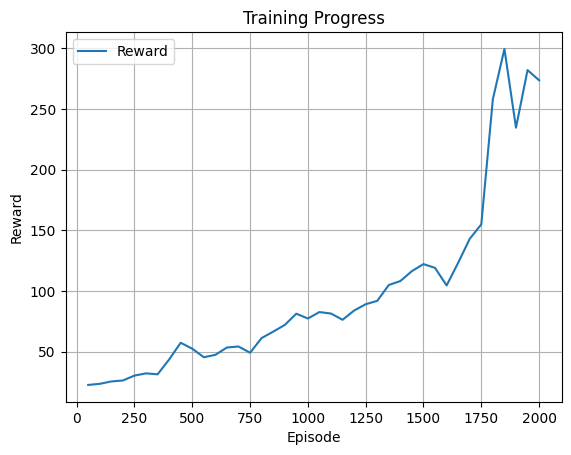

In [ ]:
# @title
plot_learning_curve(episodes, rewards)

In [ ]:
# @title
# It's good practice to create a new environment for evaluation
eval_env = gym.make(ENV_NAME, render_mode="human")
state, _ = eval_env.reset()
done = False
truncated = False
final_episode_reward = 0

# Set policy to evaluation mode (important if you had dropout/batchnorm, though less common in simple FC networks)
reinforce_agent.policy_net.eval()

while not done and not truncated:
    eval_env.render()
    # Use select_action for simple interaction during evaluation
    action = reinforce_agent.policy_net.select_action(state)
    state, reward, done, truncated, _ = eval_env.step(action)
    final_episode_reward += reward

print(f"Final evaluation episode reward: {final_episode_reward}")
eval_env.close()

Final evaluation episode reward: 500.0


In [ ]:
eval_env

<TimeLimit<OrderEnforcing<PassiveEnvChecker<CartPoleEnv<CartPole-v1>>>>>

## Vanilla Policy Gradient

In [5]:
# Value neural network
class FCV(nn.Module):
    def __init__(self, input_dim, hidden_dims=(32,32), activation = nn.ReLU()):
        super().__init__()
        self.activation = activation
        layers = []
        dims = [input_dim] + list(hidden_dims)
        self.hidden_dims = hidden_dims

        for in_dim, out_dim in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(in_dim, out_dim))
            layers.append(activation)
        layers.append(nn.Linear(hidden_dims[-1], 1))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.as_tensor(x, dtype=torch.float32).to(device)

        if x.dim() == 1:
            x = x.unsqueeze(0)

        return self.model(x)


In [ ]:
# @title
class VPG_Agent:
    def __init__(self, env: gym.Env, policy_net:FCDAP, value_net: FCV,
                 lr_policy: float = 1e-3, lr_value: float = 1e-3, gamma: float = 0.99,
                 entropy_beta: float = 0.01, max_grad_norm_policy: float = 0.5,
                 max_grad_norm_value: float = 0.5):

        # Now taking env and net as direct arguments
        self.env = env
        self.policy_net = policy_net.to(device) # Ensure the passed network is on the correct device
        self.value_net = value_net.to(device)


        self.optimizer_policy = optim.Adam(self.policy_net.parameters(), lr=lr_policy)
        self.optimizer_value = optim.Adam(self.value_net.parameters(), lr=lr_value) # Optimizer for value net

        self.gamma = gamma
        self.entropy_beta = entropy_beta
        self.max_grad_norm_policy = max_grad_norm_policy
        self.max_grad_norm_value = max_grad_norm_value

        # Stores for an episode
        self.log_probs = []
        self.states = []
        self.rewards = []
        self.entropies = []

    def store_transition(self, state, log_prob: torch.Tensor, reward: float, entropy: torch.Tensor):
        """
        Stores the state, log probability,and reward of the taken action for a step.
        """
        self.states.append(state)
        self.log_probs.append(log_prob)
        self.rewards.append(reward)
        self.entropies.append(entropy)

    def calculate_returns(self) -> torch.Tensor:
        """
        Calculates discounted returns for an entire episode.
        """
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G) # Insert at the beginning to maintain order (G_0, G_1, ...)

        returns = torch.tensor(returns, dtype=torch.float32, device=device)
        # Normalization is often applied here for stability.
        # returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def update(self):
        """
        Performs a policy update using the VPG with a value-based baseline.
        This method is called once per episode after the episode finishes.
        """

        # Convert stored states to a tensor
        states_tensor = torch.as_tensor(np.array(self.states), dtype=torch.float32, device=device)

        returns = self.calculate_returns()

        # Get predicted values from the value network
        predicted_values = self.value_net(states_tensor).squeeze(-1) # Squeeze to match returns shape

         # --- Update Value Network ---
        # Value loss is MSE between predicted values and Monte Carlo returns
        value_loss = F.mse_loss(predicted_values, returns.detach()) # Detach returns to prevent grad flow

        # Apply gradient clipping for the value network.
        self.optimizer_value.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.value_net.parameters(), self.max_grad_norm_value)
        self.optimizer_value.step()

        # --- Calculate Advantages ---
        # Advantages are returns minus predicted values (baseline)
        # Detach predicted_values to prevent gradients flowing from policy loss to value network
        advantages = returns - predicted_values.detach()

        # --- Update Policy Network ---
        log_probs_tensor = torch.cat(self.log_probs)
        entropies_tensor = torch.cat(self.entropies)
        # Policy loss is negative sum of log_prob * advantage
        policy_loss = - (log_probs_tensor * advantages).mean() - self.entropy_beta * entropies_tensor.mean()

        # Apply gradient clipping for the policy network
        self.optimizer_policy.zero_grad()
        policy_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), self.max_grad_norm_policy)
        self.optimizer_policy.step()



        # Clear episode data for the next episode
        self.log_probs = []
        self.rewards = []
        self.states = []
        self.entropies = []

        return policy_loss.item(), value_loss.item()

In [ ]:
# @title
def train_VGP(agent: VPG_Agent, num_episodes: int = 1000, print_interval: int = 50):
    """
    Trains the REINFORCE agent for a specified number of episodes.
    """
    episode_rewards = deque(maxlen=100) # For tracking average reward over last 100 episodes

    print(f"Starting VPG training on {agent.env.spec.id}...")

    # Lists to store data for plotting
    plot_episodes = []
    plot_avg_rewards = []
    plot_policy_losses = []
    plot_value_losses = []



    for episode in range(1, num_episodes + 1):
        state, _ = agent.env.reset()
        terminated = False
        truncated = False
        episode_reward = 0

        # Generate a trajecotory.
        while not terminated and not truncated:
            action, is_exploratory, log_prob, entropy = agent.policy_net.full_pass(state)

            next_state, reward, terminated, truncated, _ = agent.env.step(action)

            agent.store_transition(state, log_prob, reward, entropy)

            state = next_state
            episode_reward += reward

        # update agent.
        policy_loss, value_loss = agent.update()

        episode_rewards.append(episode_reward)

        # monitor
        if episode % print_interval == 0:
            avg_reward = np.mean(episode_rewards)
            plot_episodes.append(episode)
            plot_avg_rewards.append(avg_reward)
            plot_policy_losses.append(policy_loss)
            plot_value_losses.append(value_loss)
            print(f"Episode {episode}/{num_episodes}, Avg Reward (last {episode_rewards.maxlen}): {avg_reward:.2f}")

            # Example early stopping condition for CartPole-v1
            if agent.env.spec.id == 'CartPole-v1' and avg_reward >= 475:
                print(f"Environment {agent.env.spec.id} solved at episode {episode}!")
                break

    agent.env.close()
    return plot_episodes, plot_avg_rewards, plot_value_losses, plot_policy_losses

In [ ]:
# @title
# --- Step 1: Initialize the Environment ---
LR_POLICY = 1e-3
LR_VALUE = 1e-3 # Learning rate for the value network
MAX_GRAD_NORM_POLICY = 1.0 # New: Max gradient norm for policy
MAX_GRAD_NORM_VALUE = 1.0
ENTROPY_BETA = 0.01
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- Step 2: Initialize your FCDAP Policy Network ---
# Note: I'm using your FCDAP code directly, including init_std=1.0.
# As discussed previously, for nn.ReLU, a smaller init_std (e.g., 0.01)
# or orthogonal initialization is often more stable.
policy_net = FCDAP(input_dim=state_dim, output_dim=action_dim, hidden_dims=(64, 64), init_std=0.01) # Changed init_std to a more typical value for better stability
value_net = FCV(input_dim=state_dim, hidden_dims=(64, 64))

# --- Step 3: Create the REINFORCE Agent with the initialized env and net ---
vpg_agent = VPG_Agent(
    env=env,
    policy_net=policy_net,
    value_net=value_net,
    lr_policy=LR_POLICY,
    lr_value = LR_POLICY,
    gamma=GAMMA,
    entropy_beta=ENTROPY_BETA,
    max_grad_norm_policy=MAX_GRAD_NORM_POLICY, # Pass to agent
    max_grad_norm_value=MAX_GRAD_NORM_VALUE
)

print(f"Training REINFORCE agent on {env.spec.id} using your FCDAP network...")
episodes, rewards, policy_losses, value_losses = train_VGP(vpg_agent, num_episodes=NUM_EPISODES)

Training REINFORCE agent on CartPole-v1 using your FCDAP network...
Starting VPG training on CartPole-v1...
Episode 50/2000, Avg Reward (last 100): 24.10
Episode 100/2000, Avg Reward (last 100): 22.42
Episode 150/2000, Avg Reward (last 100): 22.97
Episode 200/2000, Avg Reward (last 100): 26.35
Episode 250/2000, Avg Reward (last 100): 31.56
Episode 300/2000, Avg Reward (last 100): 41.09
Episode 350/2000, Avg Reward (last 100): 48.37
Episode 400/2000, Avg Reward (last 100): 59.50
Episode 450/2000, Avg Reward (last 100): 71.06
Episode 500/2000, Avg Reward (last 100): 80.55
Episode 550/2000, Avg Reward (last 100): 93.70
Episode 600/2000, Avg Reward (last 100): 113.32
Episode 650/2000, Avg Reward (last 100): 159.23
Episode 700/2000, Avg Reward (last 100): 296.11
Episode 750/2000, Avg Reward (last 100): 390.48
Episode 800/2000, Avg Reward (last 100): 399.09
Episode 850/2000, Avg Reward (last 100): 437.86
Episode 900/2000, Avg Reward (last 100): 469.47
Episode 950/2000, Avg Reward (last 100):

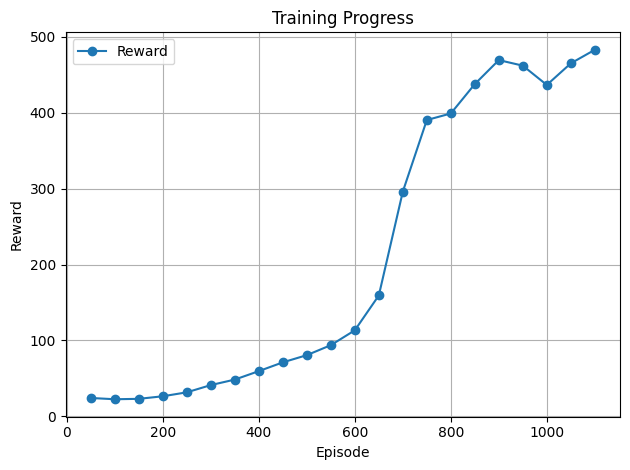

In [ ]:
# @title
plot_learning_curve(episodes, rewards)

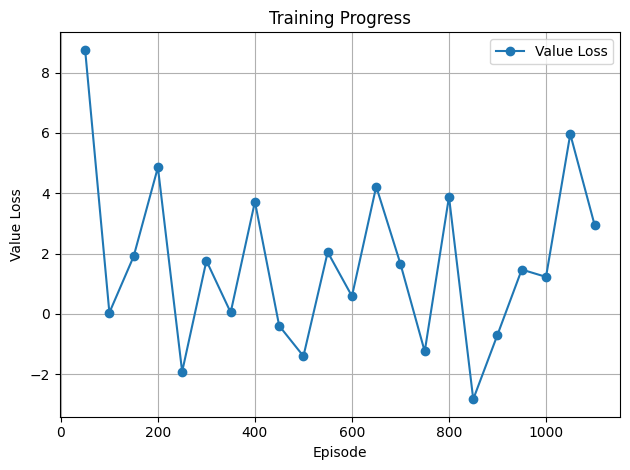

In [ ]:
plot_learning_curve(episodes, value_losses, label='Value Loss', title='Training Progress')

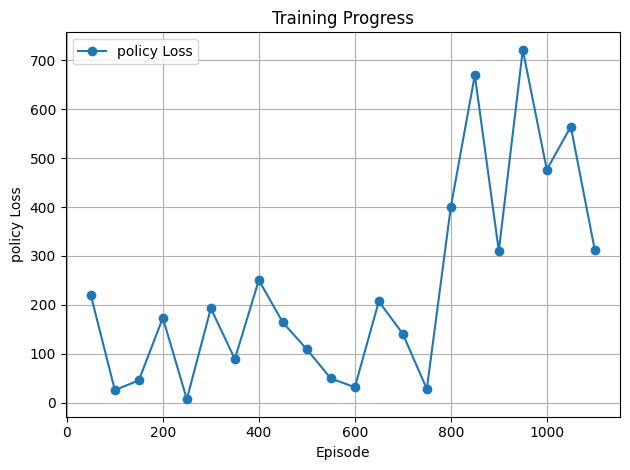

In [ ]:
plot_learning_curve(episodes, policy_losses, label='policy Loss', title='Training Progress')

## A3C: Parallel policy updates. Introduce Ensemble average.

In [6]:
import threading

class GlobalA3C:
    def __init__(self, policy_net: FCDAP, value_net: FCV, lr_policy, lr_value):

        self.policy_net = policy_net.to(device)
        self.value_net = value_net.to(device)

        # Make global networks share memory for multi-threading
        self.policy_net.share_memory()
        self.value_net.share_memory()

        self.optimizer_policy = optim.Adam(self.policy_net.parameters(), lr=lr_policy)
        self.optimizer_value = optim.Adam(self.value_net.parameters(), lr=lr_value)

        # Global counters/trackers
        self.global_episode = 0
        self.global_max_reward = -np.inf
        self.lock = threading.Lock() # For protecting global updates and counters
        self.episode_rewards_deque = deque(maxlen=100) # Global reward tracking

### A3C with Debug
The first version is found to not learn at all. Using the debug mode, we identitfy that the local gradient is not passed to the global net. This problem is now fixed.

In [7]:
# With Debug mode

# @title
# --- Worker Thread Class ---
class Worker(threading.Thread):
    def __init__(self, worker_id, global_a3c: GlobalA3C, env:gym.Env, gamma, entropy_beta,
                 n_steps, max_grad_norm_policy, max_grad_norm_value, max_episodes_per_worker,
                 num_episodes: int = 1000, print_interval: int = 50,
                 debug_mode: bool = False):

        super().__init__()
        self.worker_id = worker_id
        self.global_a3c = global_a3c
        self.env = env
        self.gamma = gamma
        self.entropy_beta = entropy_beta
        self.n_steps = n_steps
        self.max_grad_norm_policy = max_grad_norm_policy
        self.max_grad_norm_value = max_grad_norm_value
        self.max_episodes_per_worker = max_episodes_per_worker
        self.num_episodes = num_episodes
        self.print_interval = print_interval
        self.debug_mode = debug_mode

        # Get architecture details from the global network instances
        state_dim = self.env.observation_space.shape[0]
        action_dim = self.env.action_space.n
        policy_hidden_dims = self.global_a3c.policy_net.hidden_dims
        policy_init_std = self.global_a3c.policy_net.init_std
        value_hidden_dims = self.global_a3c.value_net.hidden_dims


        # Local networks for this worker
        self.local_policy_net = FCDAP(
            input_dim=state_dim,
            output_dim=action_dim,
            hidden_dims=policy_hidden_dims,
            init_std=policy_init_std
        ).to(device)
        self.local_value_net = FCV(
            input_dim=state_dim,
            hidden_dims=value_hidden_dims
        ).to(device)

        # Buffers for collecting n_steps experiences
        self.states = []
        self.actions = [] # Not directly used for loss, but useful for debugging
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.entropies = []

    def sync_local_networks(self):
        self.local_policy_net.load_state_dict(self.global_a3c.policy_net.state_dict())
        self.local_value_net.load_state_dict(self.global_a3c.value_net.state_dict())

    def calculate_n_step_returns_and_advantages(self, next_state_value, terminated, truncated):
        # Calculate N-step returns
        n_step_returns = []
        R = next_state_value # Bootstrap from the value of the state after n_steps
        if terminated or truncated: # If episode ended, R is 0 for subsequent steps
            R = 0

        # Calculate returns backwards from the last step in the segment
        for r in reversed(self.rewards):
            R = r + self.gamma * R
            n_step_returns.insert(0, R)


        n_step_returns = torch.tensor(n_step_returns, dtype=torch.float32, device=device)
        n_step_returns = n_step_returns.unsqueeze(-1)


        # Calculate advantages
        # predicted_values = torch.tensor(self.values, dtype=torch.float32, device=device) # Values collected from local_value_net
        predicted_values_for_advantage = torch.cat(self.values)
        advantages = n_step_returns - predicted_values_for_advantage # A_t = G_t(n) - V(s_t)

        return n_step_returns, advantages

    def update_global_networks(self, n_step_returns, advantages):
        # Prepare tensors from collected data
        log_probs_tensor = torch.cat(self.log_probs)
        entropies_tensor = torch.cat(self.entropies)
        predicted_values_tensor = torch.cat(self.values) # These are from local_value_net, but we re-predict for the loss

        # Calculate losses
        # Value loss: MSE between predicted values and n-step returns
        value_loss = F.mse_loss(predicted_values_tensor, n_step_returns.detach())

        # Policy loss with entropy regularization
        policy_loss = - (log_probs_tensor * advantages.detach().squeeze(-1)).sum() - self.entropy_beta * entropies_tensor.sum() # Sum over n-steps

        # --- Step 1: Compute gradients on LOCAL networks ---
        # Zero gradients for local networks BEFORE backward pass
        self.local_policy_net.zero_grad()
        self.local_value_net.zero_grad()

        # Combine losses for a single backward pass (often cleaner)
        # You might want to weigh value_loss, e.g., total_loss = policy_loss + 0.5 * value_loss
        total_loss = policy_loss + value_loss

        # Compute gradients for LOCAL networks
        total_loss.backward()
        # After this, self.local_policy_net.parameters().grad and self.local_value_net.parameters().grad
        # will contain the computed gradients.


        with self.global_a3c.lock:
            # --- DEBUGGING: Check Policy Network Updates ---
            # Get a parameter before the update (e.g., the weight of the first linear layer)
            # Use .data to get the raw tensor and .clone() to ensure you have a copy, not a view
            policy_global_param_before = self.global_a3c.policy_net.model[0].weight.data.clone()
            self.global_a3c.optimizer_policy.zero_grad()
            self.global_a3c.optimizer_value.zero_grad()


            # Transfer (accumulate) gradients from local to global networks
            # This iterates through corresponding parameters and copies local_grad to global_grad
            for global_param, local_param in zip(self.global_a3c.policy_net.parameters(), self.local_policy_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # --- DEBUGGING: Check Global Policy Gradients AFTER accumulation ---
            if self.debug_mode: # <--- WRAP IN DEBUG CHECK
                policy_global_grad = self.global_a3c.policy_net.model[0].weight.grad
                if policy_global_grad is None:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad is still None AFTER transfer! (Issue in transfer loop?)")
                elif policy_global_grad.norm().item() == 0.0:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad is all zeros AFTER transfer! (Loss problem or very small grads)")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy Grad Norm (after transfer): {policy_global_grad.norm().item():.6f}")


            # Now, clip the gradients on the GLOBAL policy network's parameters
            torch.nn.utils.clip_grad_norm_(self.global_a3c.policy_net.parameters(), self.max_grad_norm_policy)

            # Perform the optimization step on the GLOBAL policy network
            self.global_a3c.optimizer_policy.step()

            # --- DEBUGGING: Capture Global Policy param AFTER update ---
            if self.debug_mode: # <--- WRAP IN DEBUG CHECK
                policy_global_param_after = self.global_a3c.policy_net.model[0].weight.data.clone()
                if torch.equal(policy_global_param_before, policy_global_param_after):
                    print(f"*** CRITICAL DEBUG: Worker {self.worker_id} Global Policy network parameters DID NOT change! (Optimizer step failed?) ***")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Policy network parameters CHANGED. (Policy norm diff: {(policy_global_param_before - policy_global_param_after).norm().item():.6e})")

            # --- DEBUGGING: Capture Global Value param BEFORE update ---
            if self.debug_mode: # <--- WRAP IN DEBUG CHECK
                value_global_param_before = self.global_a3c.value_net.model[0].weight.data.clone()

            # Transfer gradients from local to global value network
            for global_param, local_param in zip(self.global_a3c.value_net.parameters(), self.local_value_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # Transfer (accumulate) gradients from local to global value network
            for global_param, local_param in zip(self.global_a3c.value_net.parameters(), self.local_value_net.parameters()):
                if local_param.grad is not None:
                    if global_param.grad is None:
                        global_param.grad = local_param.grad.data.clone()
                    else:
                        global_param.grad.data.add_(local_param.grad.data)

            # --- DEBUGGING: Check Global Value Gradients AFTER accumulation ---
            if self.debug_mode: # <--- WRAP IN DEBUG CHECK
                value_global_grad = self.global_a3c.value_net.model[0].weight.grad
                if value_global_grad is None:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad is still None AFTER transfer! (Issue in transfer loop?)")
                elif value_global_grad.norm().item() == 0.0:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad is all zeros AFTER transfer! (Loss problem or very small grads)")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Value Grad Norm (after transfer): {value_global_grad.norm().item():.6f}")

            torch.nn.utils.clip_grad_norm_(self.global_a3c.value_net.parameters(), self.max_grad_norm_value)
            self.global_a3c.optimizer_value.step()

            # --- DEBUGGING: Capture Global Value param AFTER update ---
            if self.debug_mode: # <--- WRAP IN DEBUG CHECK
                value_global_param_after = self.global_a3c.value_net.model[0].weight.data.clone()
                if torch.equal(value_global_param_before, value_global_param_after):
                    print(f"*** CRITICAL DEBUG: Worker {self.worker_id} Global Value network parameters DID NOT change! (Optimizer step failed?) ***")
                else:
                    print(f"DEBUG: Worker {self.worker_id} Global Value network parameters CHANGED. (Value norm diff: {(value_global_param_before - value_global_param_after).norm().item():.6e})")


        # Clear buffers
        self.states = []
        self.actions = []
        self.rewards = []
        self.log_probs = []
        self.values = []
        self.entropies = []

        return policy_loss.item(), value_loss.item()


    def run(self):
        worker_episode_count = 0
        state, _ = self.env.reset()
        total_reward_for_current_episode = 0

        while self.global_a3c.global_episode < self.max_episodes_per_worker: # Total episodes to run across all workers
            self.sync_local_networks() # Sync local with global before collecting segment
            # Clear buffers for *this n_steps segment* before collecting new experience
            self.states.clear()
            self.actions.clear()
            self.rewards.clear() # Cleared for each new n_steps segment
            self.log_probs.clear()
            self.values.clear()
            self.entropies.clear()

            terminated_segment = False
            truncated_segment = False

            for _ in range(self.n_steps): # Collect n_steps experience
                # Get action and value from local networks
                action, _, log_prob, entropy = self.local_policy_net.full_pass(state)
                value = self.local_value_net(state) # Get value from local value net

                next_state, reward, terminated_segment, truncated_segment, _ = self.env.step(action)

                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.entropies.append(entropy)

                total_reward_for_current_episode += reward
                state = next_state

                if terminated_segment or truncated_segment:
                    break

            # Calculate the value of the next state for bootstrapping (if not done)
            if terminated_segment or truncated_segment:
                next_state_value = 0.0 # Terminal state has 0 value
            else:
                with torch.no_grad():
                    next_state_value = self.local_value_net(state).item() # Bootstrap from next_state's value

            # Update global networks and clear buffers
            n_step_returns, advantages = self.calculate_n_step_returns_and_advantages(next_state_value, terminated_segment, truncated_segment)
            policy_loss, value_loss = self.update_global_networks(n_step_returns, advantages)


            # --- Global Logging and Episode Management ---
            if terminated_segment or truncated_segment: # Check if a *full episode* just finished in this segment
                with self.global_a3c.lock:
                    self.global_a3c.global_episode += 1 # Increment global episode counter ONLY when an episode ends
                    # Append the *full* episode reward to the global deque
                    self.global_a3c.episode_rewards_deque.append(total_reward_for_current_episode)

                    # Get current global episode and avg reward *after* incrementing/appending
                    current_global_episode = self.global_a3c.global_episode
                    # Ensure conversion to list before np.mean if deque is empty or has fewer than 2 elements
                    avg_reward = np.mean(list(self.global_a3c.episode_rewards_deque))

                    # Print progress only if an episode just finished and it's a print interval
                    if current_global_episode % self.print_interval == 0:
                        print(f"Global Episode {current_global_episode}/{self.num_episodes}, Worker {self.worker_id}, Avg Reward (last {len(self.global_a3c.episode_rewards_deque)} episodes): {avg_reward:.2f}")
                        if self.env.spec.id == 'CartPole-v1' and avg_reward >= 475:
                            print(f"Environment {self.env.spec.id} solved at global episode {current_global_episode}!")
                            # Optional: Signal other workers to stop if target reached
                            # self.global_a3c.global_episode = self.max_episodes_per_worker + 1

                # Reset environment and episode-specific total reward for the *NEXT* episode
                state, _ = self.env.reset()
                total_reward_for_current_episode = 0 # Reset for the new episode


        self.env.close() # Close environment when worker stops

In [8]:
ENV_NAME = 'CartPole-v1'
NUM_WORKERS = 8
N_STEPS = 50
TOTAL_TRAINING_EPISODES = 1000
PRINT_INTERVAL = 100

LR_POLICY = 1e-3
LR_VALUE = 1e-3
GAMMA = 0.99
ENTROPY_BETA = 0.01
MAX_GRAD_NORM_POLICY = 10.0
MAX_GRAD_NORM_VALUE = 10.0


In [9]:
# --- Step 1: Initialize the Environment ---
env = gym.make(ENV_NAME)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

# --- Step 2: Initialize your FCDAP Policy Network ---
# Note: I'm using your FCDAP code directly, including init_std=1.0.
# As discussed previously, for nn.ReLU, a smaller init_std (e.g., 0.01)
# or orthogonal initialization is often more stable.
policy_net = FCDAP(input_dim=state_dim, output_dim=action_dim, hidden_dims=(128, 64), init_std=0.01) # Changed init_std to a more typical value for better stability
value_net = FCV(input_dim=state_dim, hidden_dims=(256, 128))

# --- Step 3: Create the REINFORCE Agent with the initialized env and net ---
global_a3c = GlobalA3C(
        policy_net=policy_net,
        value_net=value_net,
        lr_policy=LR_POLICY,
        lr_value=LR_VALUE
    )


In [10]:
# --- Create and Start Workers ---
workers = []
for i in range(NUM_WORKERS):
    env = gym.make(ENV_NAME)
    worker = Worker_debug(
        worker_id=i,
        global_a3c=global_a3c,
        env = env,
        gamma=GAMMA,
        entropy_beta=ENTROPY_BETA,
        n_steps=N_STEPS,
        max_grad_norm_policy=MAX_GRAD_NORM_POLICY,
        max_grad_norm_value=MAX_GRAD_NORM_VALUE,
        max_episodes_per_worker=TOTAL_TRAINING_EPISODES,
        num_episodes=TOTAL_TRAINING_EPISODES,
        print_interval=PRINT_INTERVAL
    )
    workers.append(worker)
    worker.start()

# --- Wait for all workers to finish ---
for worker in workers:
    worker.join()

print(f"\nTraining finished after {global_a3c.global_episode} global episodes.")

Global Episode 100/1000, Worker 4, Avg Reward (last 100 episodes): 21.66
Global Episode 200/1000, Worker 4, Avg Reward (last 100 episodes): 42.65
Global Episode 300/1000, Worker 7, Avg Reward (last 100 episodes): 139.90
Global Episode 400/1000, Worker 5, Avg Reward (last 100 episodes): 403.83
Global Episode 500/1000, Worker 2, Avg Reward (last 100 episodes): 175.29
Global Episode 600/1000, Worker 4, Avg Reward (last 100 episodes): 311.81
Global Episode 700/1000, Worker 2, Avg Reward (last 100 episodes): 312.12
Global Episode 800/1000, Worker 1, Avg Reward (last 100 episodes): 65.55
Global Episode 900/1000, Worker 5, Avg Reward (last 100 episodes): 231.50
Global Episode 1000/1000, Worker 7, Avg Reward (last 100 episodes): 453.57

Training finished after 1000 global episodes.


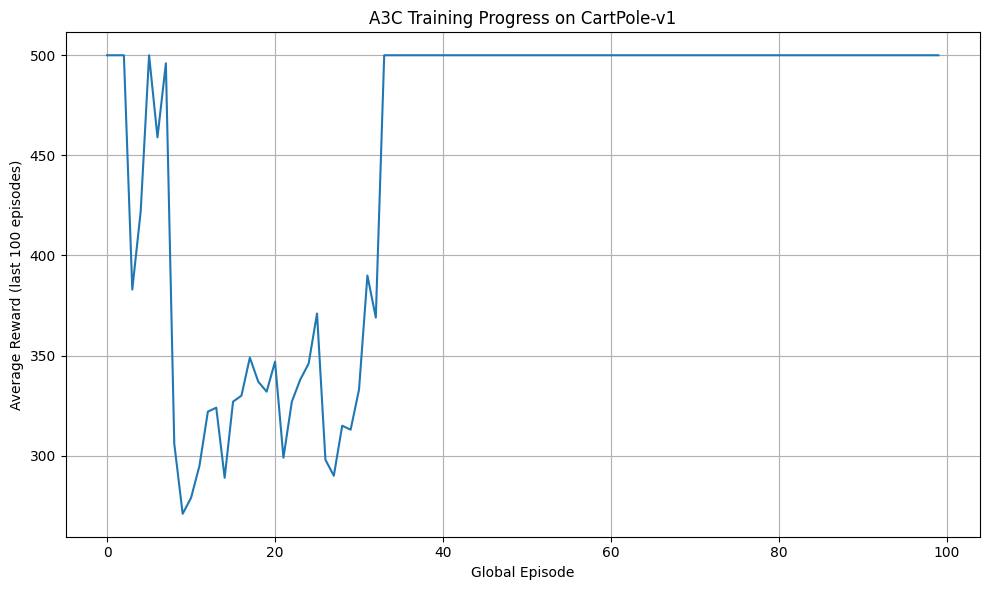

In [11]:
plt.figure(figsize=(10, 6))

plt.plot(np.arange(len(global_a3c.episode_rewards_deque)), list(global_a3c.episode_rewards_deque), linestyle='-')
plt.xlabel("Global Episode")
plt.ylabel(f"Average Reward (last 100 episodes)")
plt.title(f"A3C Training Progress on {ENV_NAME}")
plt.grid(True)
plt.tight_layout()
plt.show()

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
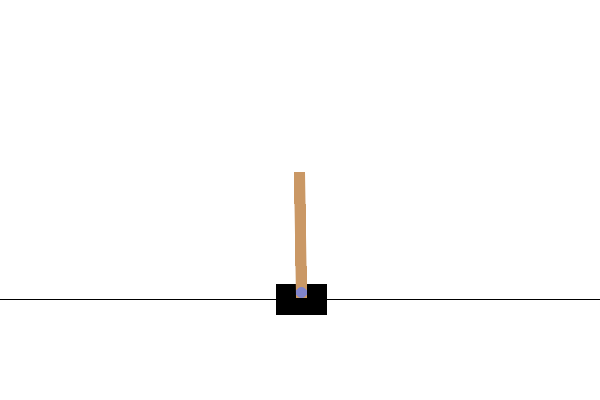

In [12]:
eval_env = gym.make(ENV_NAME, render_mode="rgb_array")
eval_env.reset()
eval_env.render()

In [14]:
# @title
eval_rewards = []
EVAL_EPISODES = 100
# Disable gradient calculations for efficiency during evaluation
with torch.no_grad():
    for episode in range(EVAL_EPISODES):
        state, _ = eval_env.reset()
        episode_reward = 0
        done = False
        truncated = False

        while not done and not truncated:
            # Get the greedy action from the global policy network
            # Move state to device if necessary (though full_pass handles it)
            state_tensor = torch.as_tensor(state, dtype=torch.float32, device=device)
            logits = global_a3c.policy_net(state_tensor)
            action = torch.argmax(logits, dim=-1).item() # Select the greedy action

            next_state, reward, done, truncated, _ = eval_env.step(action)
            episode_reward += reward
            state = next_state

        eval_rewards.append(episode_reward)

        if episode % 10 == 0:
            print(f"Evaluation Episode {episode+1}/{EVAL_EPISODES}: Reward = {episode_reward}")

# Close the evaluation environment
eval_env.close()

Evaluation Episode 1/100: Reward = 500.0
Evaluation Episode 11/100: Reward = 500.0
Evaluation Episode 21/100: Reward = 500.0
Evaluation Episode 31/100: Reward = 500.0
Evaluation Episode 41/100: Reward = 500.0
Evaluation Episode 51/100: Reward = 500.0
Evaluation Episode 61/100: Reward = 500.0
Evaluation Episode 71/100: Reward = 500.0
Evaluation Episode 81/100: Reward = 500.0
Evaluation Episode 91/100: Reward = 500.0



--- Evaluation Complete ---
Average Reward over 100 episodes: 500.00
Standard Deviation of Reward: 0.00
Congratulations! CartPole-v1 is considered SOLVED (Avg Reward >= 475)!


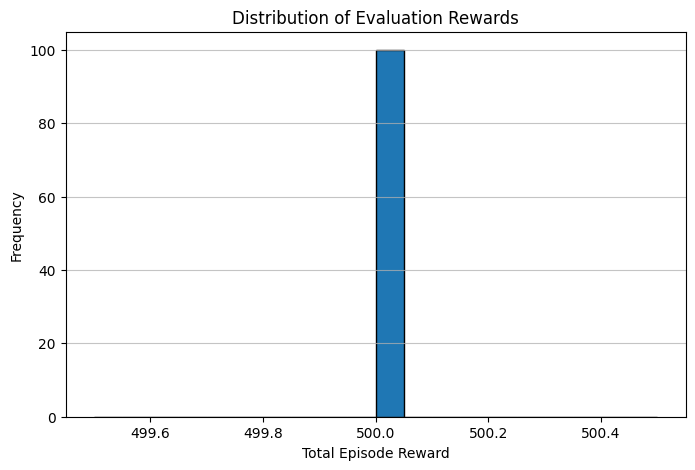

In [15]:
avg_eval_reward = np.mean(eval_rewards)
std_eval_reward = np.std(eval_rewards)

print(f"\n--- Evaluation Complete ---")
print(f"Average Reward over {EVAL_EPISODES} episodes: {avg_eval_reward:.2f}")
print(f"Standard Deviation of Reward: {std_eval_reward:.2f}")
# Check if the environment is "solved" based on its criteria (CartPole-v1: 475)
if ENV_NAME == 'CartPole-v1':
    if avg_eval_reward >= 475:
        print(f"Congratulations! {ENV_NAME} is considered SOLVED (Avg Reward >= 475)!")
    else:
        print(f"{ENV_NAME} is not yet solved (Avg Reward < 475). Keep training!")

# Optional: Plot the distribution of evaluation rewards
plt.figure(figsize=(8, 5))
plt.hist(eval_rewards, bins=20, edgecolor='black')
plt.title('Distribution of Evaluation Rewards')
plt.xlabel('Total Episode Reward')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()